# Condiciones de la asignación principal

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

# Librerias

In [4643]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as px
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (f1_score,accuracy_score,roc_auc_score)
from sklearn.feature_selection import SelectFromModel
#from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.impute import SimpleImputer

# Importar datos

In [4644]:
df_contract=pd.read_csv('files\\final_provider\contract.csv')
df_personal=pd.read_csv('files\\final_provider\personal.csv')
df_internet=pd.read_csv('files\\final_provider\internet.csv')
df_phone=pd.read_csv('files\\final_provider\phone.csv')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Santiago\AppData\Local\Temp\ipykernel_5016\833077411.py:1: SyntaxWarning: invalid escape sequence '\c'
  df_contract=pd.read_csv('files\\final_provider\contract.csv')
C:\Users\Santiago\AppData\Local\Temp\ipykernel_5016\833077411.py:2: SyntaxWarning: invalid escape sequence '\p'
  df_personal=pd.read_csv('files\\final_provider\personal.csv')
C:\Users\Santiago\AppData\Local\Temp\ipykernel_5016\833077411.py:3: SyntaxWarning: invalid escape sequence '\i'
  df_internet=pd.read_csv('files\\final_provider\internet.csv')
C:\Users\Santiago\AppData\Local\Temp\ipykernel_5016\833077411.py:4: Synt

# Preprocesamiento

## Contratos

In [4645]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [4646]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Podemos ver que los datos no tienen faltantes al tener completas las filas en cada columna, sin embargo, el tipo de objeto de la columna TotalCharges debería ser float.

In [4647]:
#Funcion para pasar columnas al formato snake_case
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s1 = s1.replace(' ','_')
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [4648]:
#Pasamos las columnas al modo snake_case
columns=df_contract.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
df_contract.columns=new_cols
print(df_contract.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [4649]:
df_contract.describe()

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


### Ausentes

In [4650]:
df_contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [4651]:
df_contract['total_charges'].value_counts()

total_charges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

Evidenciamos que la columna total_charges tiene un valor ' ' que no significa nada por lo cual veremos que impacto tiene. 

In [4652]:
df_contract[df_contract['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [4653]:
100*df_contract[df_contract['total_charges']==' ']['total_charges'].count()/df_contract.shape[0]

0.15618344455487718

In [4654]:
df_contract['total_charges']=df_contract['total_charges'].replace(' ',np.nan)

In [4655]:
df_contract['total_charges']=pd.to_numeric(df_contract['total_charges'])
df_contract['total_charges'].fillna(df_contract['total_charges'].mean(),inplace=True)

In [4656]:
100*df_contract[df_contract['total_charges']==' ']['total_charges'].count()/df_contract.shape[0]

0.0

### Duplicados

In [4657]:
df_contract.duplicated().sum()

0

In [4658]:
#Pasamos la columna total charges a float
df_contract['total_charges']=df_contract['total_charges'].astype('float')

In [4659]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


## Personal

In [4660]:
df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [4661]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [4662]:
#Pasamos las columnas al modo snake_case
columns=df_personal.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
df_personal.columns=new_cols
print(df_personal.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


El dataframe tiene datos basicos de cada cliente y con el metodo info se ve que está completo sin ausentes.

In [4663]:
df_personal.describe()

,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [4664]:
df_personal['senior_citizen'].value_counts()

senior_citizen
0    5901
1    1142
Name: count, dtype: int64

### Ausentes

In [4665]:
df_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

### Duplicados

In [4666]:
df_personal.duplicated().sum()

0

Este dataset se ve bien sin ausentes ni duplicados.

## Internet

In [4667]:
df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [4668]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [4669]:
#Pasamos las columnas al modo snake_case
columns=df_internet.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
df_internet.columns=new_cols
print(df_internet.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [4670]:
df_internet.describe()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### Ausentes

In [4671]:
df_internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

### Duplicados

In [4672]:
df_internet.duplicated().sum()

0

## Phone

In [4673]:
df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [4674]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [4675]:
#Pasamos las columnas al modo snake_case
columns=df_phone.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
df_phone.columns=new_cols
print(df_phone.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')


In [4676]:
df_phone.describe()

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


### Ausentes

In [4677]:
df_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

### Duplicados

In [4678]:
df_phone.duplicated().sum()

0

En conclusión de los 4 datasets, están sin ausentes o duplicados, y tienen información binaria acerca de a las características que el usuario tiene en el servicio de internet y telefonía, asi como las caracteristicas del contrato, medios de pago, envío de factura y caracteristicas de los clientes.

# Análisis exploratorio de datos (EDA)

## Analisis de contrato

In [4679]:
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


## ¿Que tipo de contrato es el que más escogen los clientes?

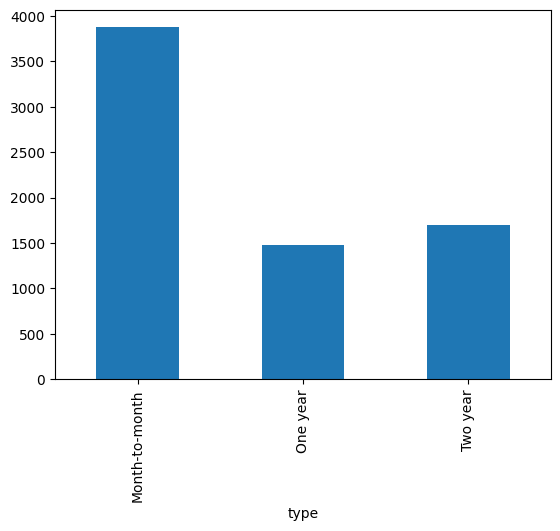

In [4680]:
df_type=df_contract.groupby(['type'])['customer_id'].count()
df_type.plot(kind='bar')
plt.show()

En general podemos ver que más personas optan por el contrato mes a mes, seguido del contrato de dos años y el contrato de un año.

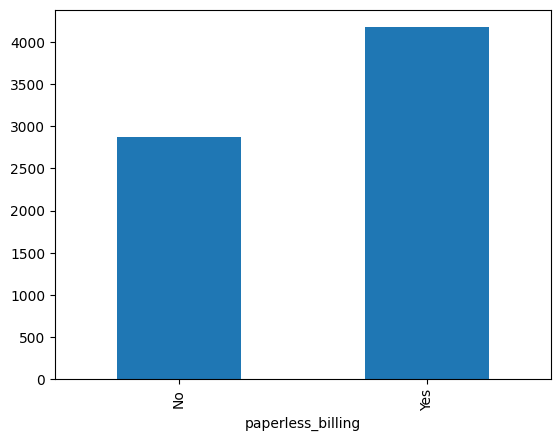

In [4681]:
df_paperless=df_contract.groupby(['paperless_billing'])['customer_id'].count()
df_paperless.plot(kind='bar')
plt.show()

La mayoría de personas prefieren recibir su factura electrónica.

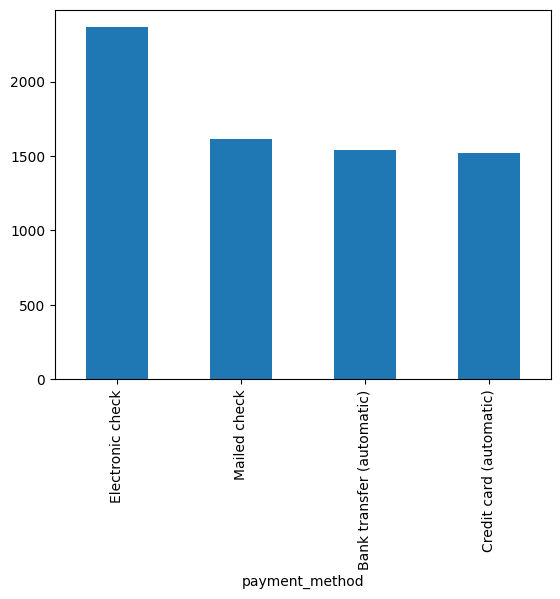

In [4682]:
df_method=df_contract.groupby(['payment_method'])['customer_id'].count()
df_method=df_method.sort_values(ascending=False)
df_method.plot(kind='bar')
plt.show()

Los clientes prefieren el pago electronico, seguido por el cheque por correo, transferencia bancaria y tarjeta de crédito (autopago).

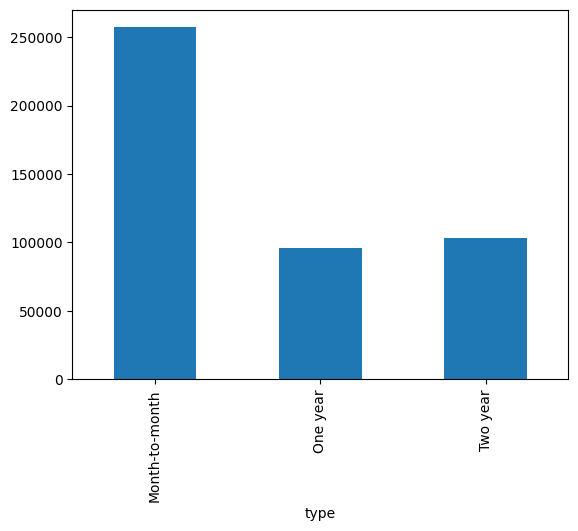

In [4683]:
df_type=df_contract.groupby(['type'])['monthly_charges'].sum()
df_type.plot(kind='bar')
plt.show()

Podemos ver que los que más cargos tienen son los que tienen contrato més a més,seguido del que tiene contrato de dos años. y el que tiene contrato de un año.

## Análisis Personal

In [4684]:
df_personal.head(10)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


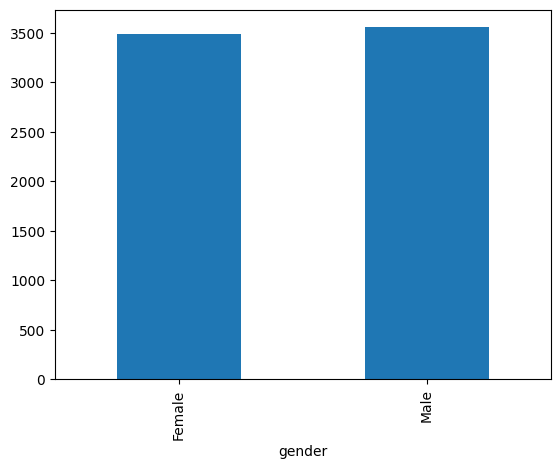

In [4685]:
df_gender=df_personal.groupby(['gender'])['customer_id'].count()
df_gender.plot(kind='bar')
plt.show()

Los clientes están balanceados, más hombres que mujeres, sin embargo, casi la misma cantidad.

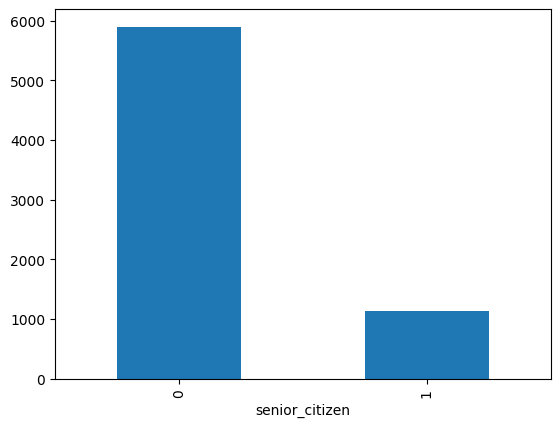

In [4686]:
df_senior=df_personal.groupby(['senior_citizen'])['customer_id'].count()
df_senior.plot(kind='bar')
plt.show()

La mayoría de los clientes no son adultos mayores.

## Internet

In [4687]:
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


## ¿Cual es el servicio de internet más demandado?

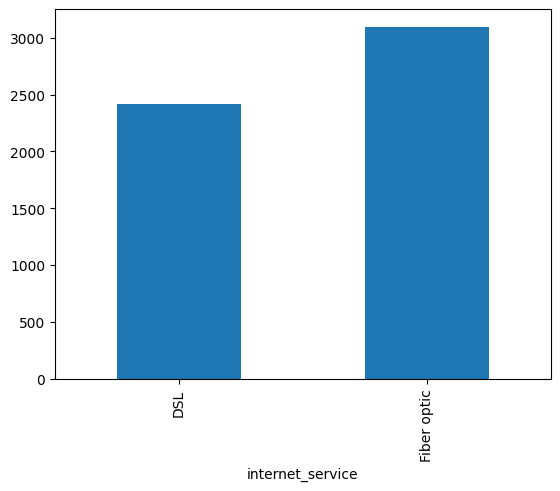

In [4688]:
df_service=df_internet.groupby(['internet_service'])['customer_id'].count()
df_service.plot(kind='bar')
plt.show()

La mayoría de los clientes utiliza fibra obtica.

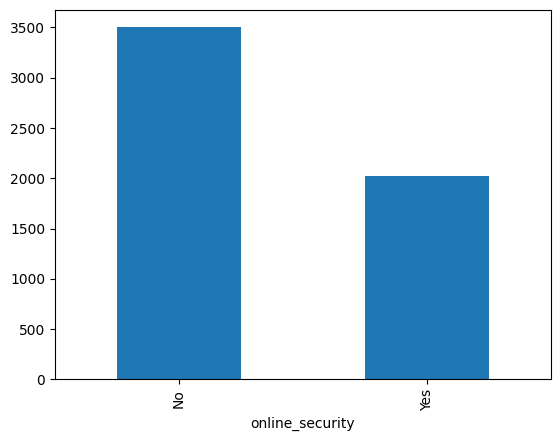

In [4689]:
df_security=df_internet.groupby(['online_security'])['customer_id'].count()
df_security.plot(kind='bar')
plt.show()

La mayoría de clientes opta por no tener seguridad.

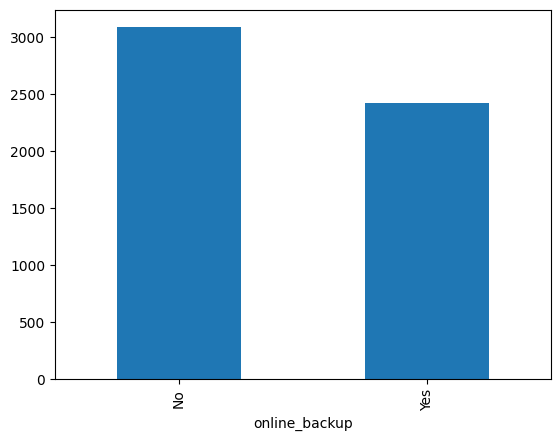

In [4690]:
df_backup=df_internet.groupby(['online_backup'])['customer_id'].count()
df_backup.plot(kind='bar')
plt.show()

La mayoría de clientes prefiere no tener respaldo de información.

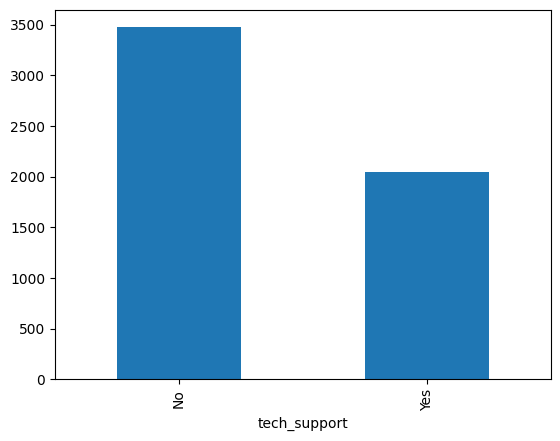

In [4691]:
df_support=df_internet.groupby(['tech_support'])['customer_id'].count()
df_support.plot(kind='bar')
plt.show()

La mayoría de clientes prefiere no tener soporte técnico

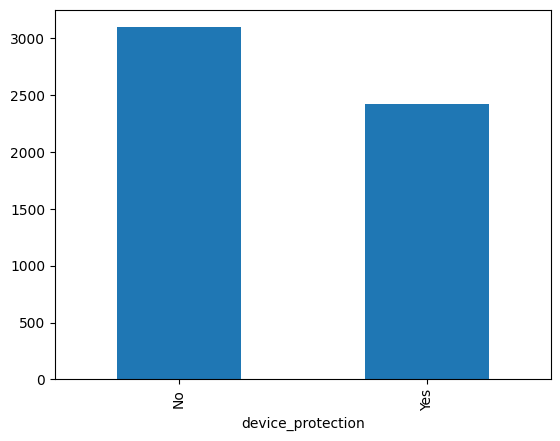

In [4692]:
df_dev_prot=df_internet.groupby(['device_protection'])['customer_id'].count()
df_dev_prot.plot(kind='bar')
plt.show()

La mayoría de clientes prefiere no tener protección de su dispositivo.

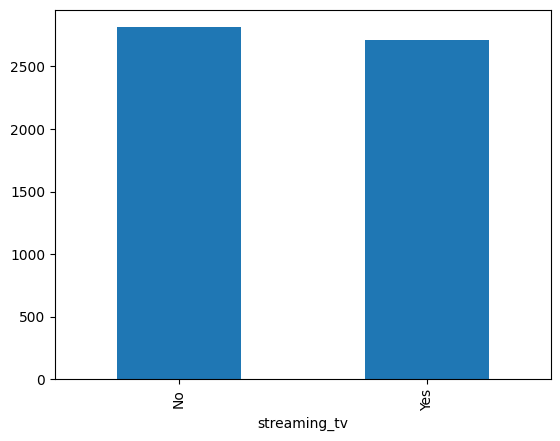

In [4693]:
df_streaming_tv=df_internet.groupby(['streaming_tv'])['customer_id'].count()
df_streaming_tv.plot(kind='bar')
plt.show()

Aunque los clientes prefieren no tener televisión, los clientes que si lo prefieren se acercan a las que no, por lo cual está balanceado este servicio.

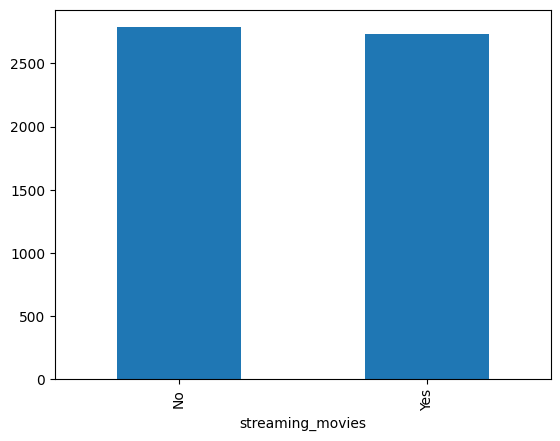

In [4694]:
df_streaming_movies=df_internet.groupby(['streaming_movies'])['customer_id'].count()
df_streaming_movies.plot(kind='bar')
plt.show()

Aunque los clientes prefieren no tener peliculas, los clientes que si lo prefieren se acercan a las que no, por lo cual está balanceado este servicio.

## Phone

In [4695]:
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


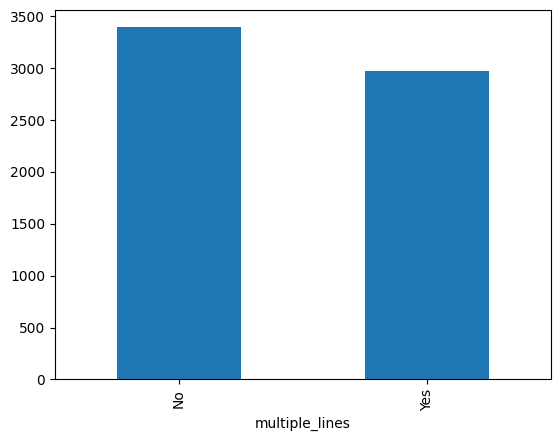

In [4696]:
df_multiple=df_phone.groupby(['multiple_lines'])['customer_id'].count()
df_multiple.plot(kind='bar')
plt.show()

La mayoría de usuarios no tienen multimples lineas.

Con el fin de facilitar el análisis, juntaremos todos los datasets en uno solo.

In [4697]:
dataframes=[df_contract,df_internet,df_phone,df_personal]
for i in dataframes:
    print(i.shape)

(7043, 8)
(5517, 8)
(6361, 2)
(7043, 5)


## Unimos los dataframes

In [4698]:
data=df_contract.merge(df_personal.merge(df_internet.merge(df_phone,how='left',on='customer_id'),how='left',on='customer_id'),how='left',on='customer_id')

In [4699]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [4700]:
data.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [4701]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines       2208
dtype: int64

In [4702]:
def cancel(data):
    if data=='No':
        return '0'
    else:
        return '1'

In [4703]:
#Creamos la columna cancel para etiquetar los datos
data['cancel']=data['end_date'].apply(cancel)
data.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,cancel
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


In [4704]:
data['end_date'].value_counts()

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [4705]:
def binary_categories(data):
    if data=='Yes':
        return 1
    elif data=='No':
        return 0

In [4706]:
binary_columns=['partner', 'dependents','paperless_billing', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']
for column in binary_columns:
       data[column]=data[column].apply(binary_categories)
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [4707]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines       2208
cancel                  0
dtype: int64

## ¿Cuales son los medios de pago más utilizados?

<Axes: xlabel='customer_id', ylabel='payment_method'>

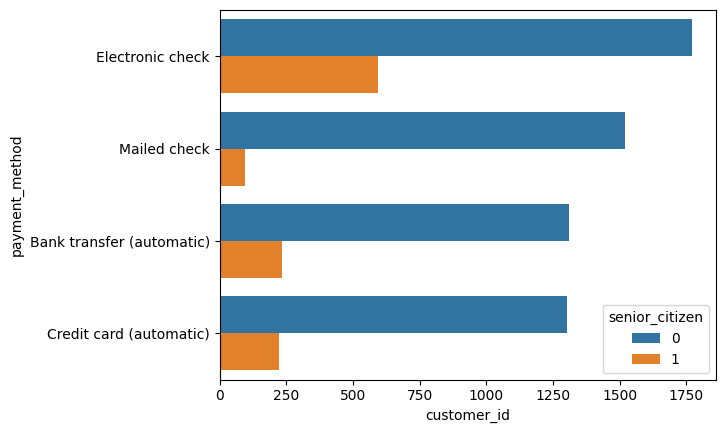

In [4708]:
df_payment_method=data.groupby(['payment_method','senior_citizen'],as_index=False)['customer_id'].count()
df_payment_method.sort_values(by='customer_id',ascending=False,inplace=True)
sns.barplot(df_payment_method,y='payment_method',x='customer_id',hue='senior_citizen',orient='h')

Sin importar si los ususarios son adutos mayores o no, el medio de pago más usado es el cheque electronico, seguido por transferencia bancaria, tarjeta de crédito (autopago) y cheque por correo.

## ¿Que tipo de factura prefieren los usuarios?

<Axes: xlabel='customer_id', ylabel='paperless_billing'>

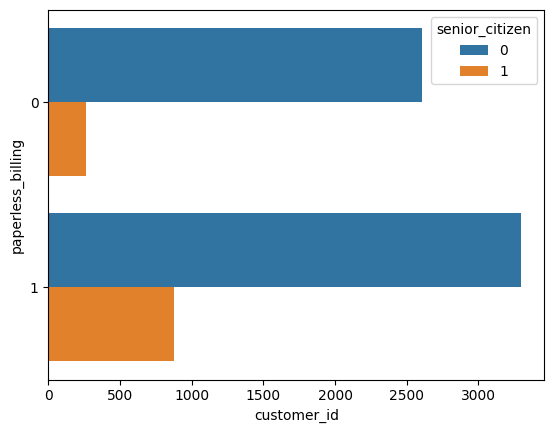

In [4709]:
df_paperless_billing=data.groupby(['paperless_billing','senior_citizen'],as_index=False)['customer_id'].count()
df_paperless_billing.sort_values(by='customer_id',ascending=False,inplace=True)
sns.barplot(df_paperless_billing,y='paperless_billing',x='customer_id',hue='senior_citizen',orient='h')

Al igual que el medio de pago, la mayoría de los usuarios sin importar que sean adultos mayores prefieren no recibir su factura por correo.

## ¿Que tipo de contrato prefieren las personas que tienen personas a cargo?

<Axes: xlabel='total_charges', ylabel='type'>

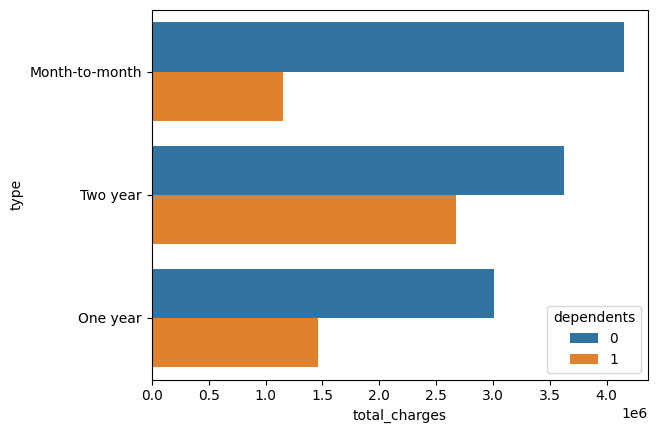

In [4710]:
df_total_charges=data.groupby(['type','dependents'],as_index=False)['total_charges'].sum()
df_total_charges.sort_values(by='total_charges',ascending=False,inplace=True)
sns.barplot(df_total_charges,y='type',x='total_charges',hue='dependents',orient='h')

La mayoría de los clientes tienen más cargos y no tienen personas dependientes de ellos, además podemos ver que las personas que pagan mes a mes tienen más cargos

<Axes: xlabel='total_charges', ylabel='internet_service'>

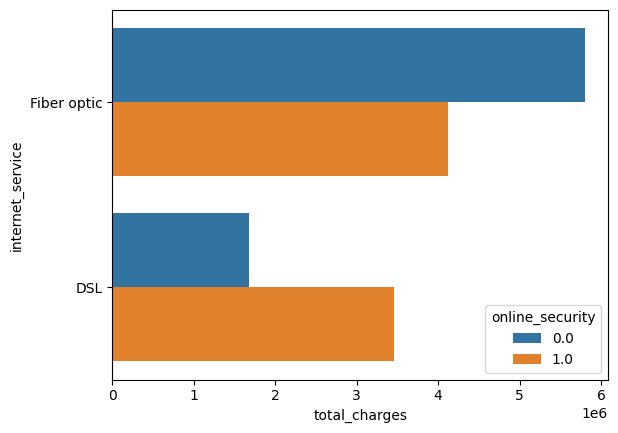

In [4711]:
df_internet_service_1=data.groupby(['internet_service','online_security'],as_index=False)['total_charges'].sum()
df_internet_service_1.sort_values(by='total_charges',ascending=False,inplace=True)
sns.barplot(df_internet_service_1,y='internet_service',x='total_charges',hue='online_security',orient='h')

Podemos ver que los que tienen fibra obtica y no tiene seguridad online pagan más que los que si la tienen.

<Axes: xlabel='customer_id', ylabel='internet_service'>

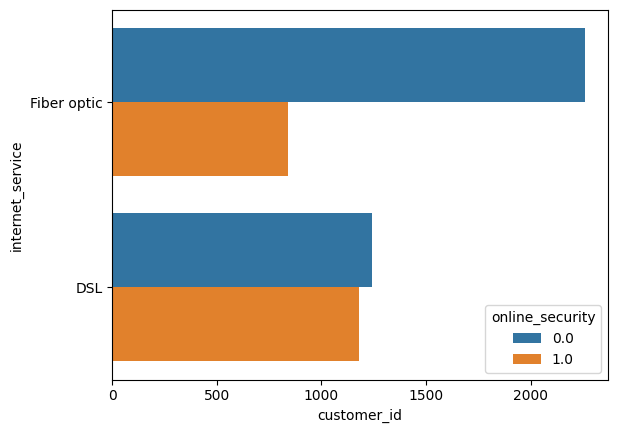

In [4712]:
df_internet_service_1=data.groupby(['internet_service','online_security'],as_index=False)['customer_id'].count()
df_internet_service_1.sort_values(by='customer_id',ascending=False,inplace=True)
sns.barplot(df_internet_service_1,y='internet_service',x='customer_id',hue='online_security',orient='h')

Con este gráfico podemos confirmar que las personas que tienen el servicio DSL prefieren tener seguridad online que no tener. Por otro lado los que tienen fibra optica prefieren no tener seguridad online, y tienen más cargos que el servicio DSL.

## ¿Cual es la tasa de cancelación y que caracteristicas tienen los usuarios que cancelan y los que no?

In [4713]:
print('Tasa de cancelación: ',100*data[data['cancel']=='1']['customer_id'].count()/data.shape[0])

Tasa de cancelación:  26.536987079369588


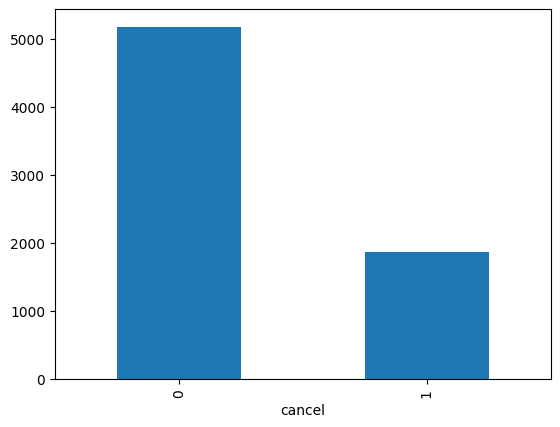

In [4714]:
data_cancel_rate=data.groupby(['cancel'])['customer_id'].count()
data_cancel_rate.plot(kind='bar')
plt.show()

Podemos ver que la tasa de cancelación es del 32% lo cual es bastante alto teniendo en cuenta solo 4 meses, veremos más a fondo que tipo de caracteristicas tiene el plan de cada uno de los que cancelaron y los que no cancelaron.

<Axes: xlabel='customer_id', ylabel='internet_service'>

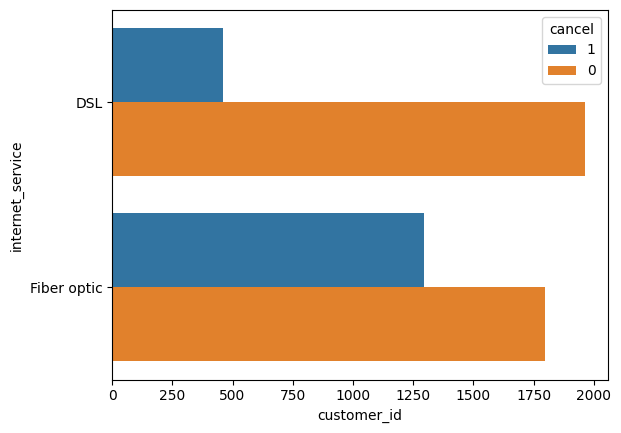

In [4715]:
df_internet_service_2=data.groupby(['internet_service','cancel'],as_index=False)['customer_id'].count()
df_internet_service_2.sort_values(by='cancel',ascending=False,inplace=True)
sns.barplot(df_internet_service_2,y='internet_service',x='customer_id',hue='cancel',orient='h')

Los que cancelan y los que no cancelan siguen la misma tendencia a tener más fibra optica que DSL.

<Axes: xlabel='customer_id', ylabel='type'>

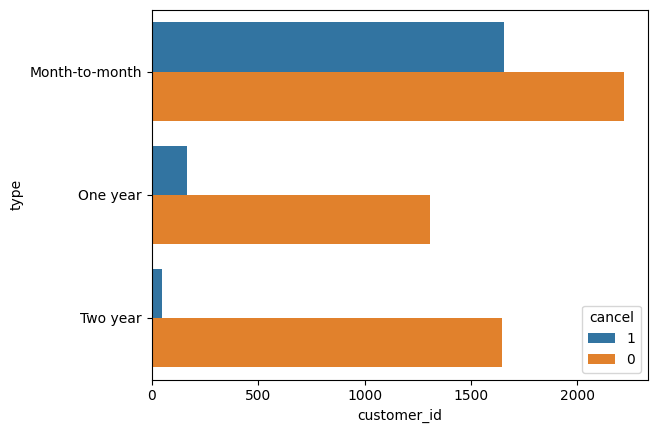

In [4716]:
df_payment_type=data.groupby(['type','cancel'],as_index=False)['customer_id'].count()
df_payment_type.sort_values(by='cancel',ascending=False,inplace=True)
sns.barplot(df_payment_type,y='type',x='customer_id',hue='cancel',orient='h')

Aqui la diferencia se ve marcada, debido a que la mayoría de clientes que cancelan tienen el plan mes a mes, mientras que los que tienen planes anuales no suelen cancelar, sino que se mantienen.

<Axes: xlabel='total_charges', ylabel='type'>

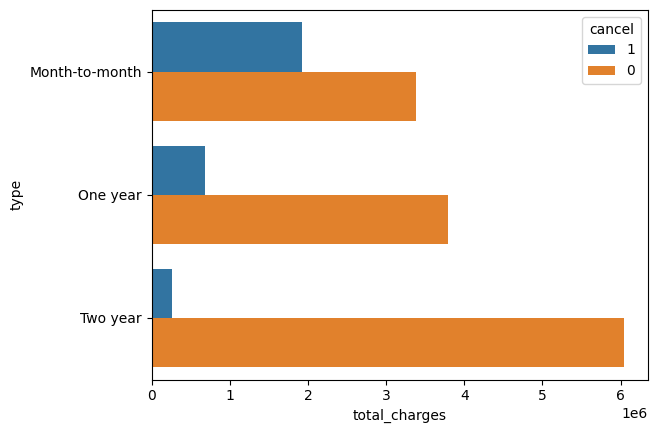

In [4717]:
df_expenses=data.groupby(['type','cancel'],as_index=False)['total_charges'].sum()
df_expenses.sort_values(by='cancel',ascending=False,inplace=True)
sns.barplot(df_expenses,y='type',x='total_charges',hue='cancel',orient='h')

Podemos ver que los que cancelan gastan más en los planes mes a mes, lo que tiene complementa el anterior análisis.

In [4718]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'cancel'],
      dtype='object')

<Axes: xlabel='customer_id', ylabel='cancel'>

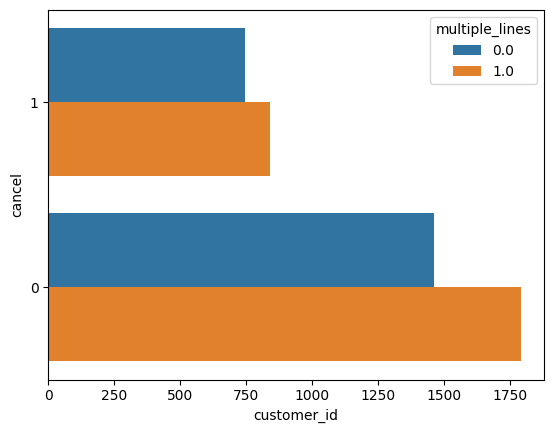

In [4719]:
df_multiline=data.groupby(['cancel','multiple_lines'],as_index=False)['customer_id'].count()
df_multiline.sort_values(by='cancel',ascending=False,inplace=True)
sns.barplot(df_multiline,y='cancel',x='customer_id',hue='multiple_lines',orient='h')

Las personas que tienen multiples lineas suelen cancelar más que las que no lo tienen, por lo que puede ser un servicio desatendido.

<Axes: xlabel='customer_id', ylabel='payment_method'>

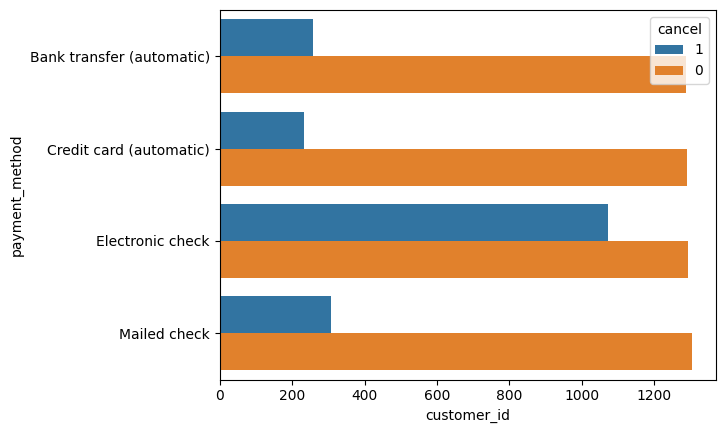

In [4720]:
df_p_method=data.groupby(['payment_method','cancel'],as_index=False)['customer_id'].count()
df_p_method.sort_values(by='cancel',ascending=False,inplace=True)
sns.barplot(df_p_method,y='payment_method',x='customer_id',hue='cancel',orient='h')

<Axes: xlabel='customer_id', ylabel='cancel'>

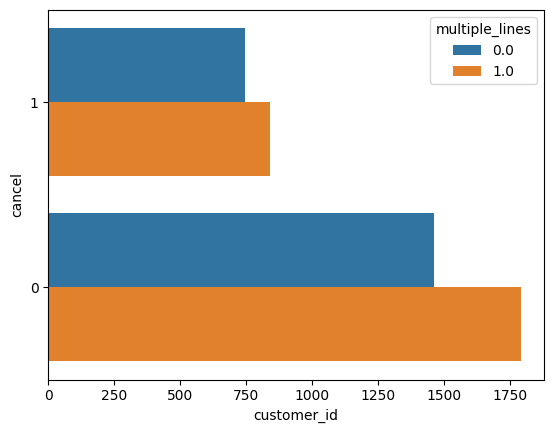

In [4721]:
df_multiline=data.groupby(['cancel','multiple_lines'],as_index=False)['customer_id'].count()
df_multiline.sort_values(by='cancel',ascending=False,inplace=True)
sns.barplot(df_multiline,y='cancel',x='customer_id',hue='multiple_lines',orient='h')

De la ultima pregunta, podemos concluir que la mayoría de usuarios que cancelan tienen el plan mes a mes, pagan con cheque electronico, tienen el servicio de internet de fibra optica y los servicios que más utilizan son la multilinea, las peliculas, la televisión y la protección de los dispositivos. La tasa de cancelación es del **32%**.

## Plan de trabajo

1. Segmentar los datos

2. Balanceo de datos

3. Separación de datos de entrenamiento, validación y testeo

4. Entrenamiento de modelo de clasificación

5. Testeo del modelo de clasificación



Primero debemos filtrar los datos por el tipo de contrato de más frecuente entre los que van a cancelar, en este caso el de 'mes a mes', posteriormente realizamos todo el proceso de entrenamiento del modelo de entrenamiento que nos permita clasificar a los clientes que puedan cancelar. 

Para realizar el algoritmo debemos balancear los datos, debido a que el 32% de los datos son clientes que cancelan, posteriormente entrenaremos y probaremos varios algoritmos de clasificación con potenciación del gradiente para obtener una exactitud y calidad del modelo alta. Posteriormente probaremos el mejor modelo con los datos de testeo para determinar la **tasa de cancelación**. 

# Código solución

In [4722]:
data.head()
data['cancel']=pd.to_numeric(data['cancel'])

## Codificamos nuestros datos categoricos

In [4723]:
data_model=data.drop(['customer_id','begin_date','end_date'],axis=1)

In [4724]:
one_hot=pd.get_dummies(data_model[['type','payment_method','internet_service']])
data_model = pd.concat([data_model, one_hot], axis=1).drop(columns=['type','payment_method','internet_service'])

In [4725]:
data_model.dtypes

paperless_billing                             int64
monthly_charges                             float64
total_charges                               float64
gender                                        int64
senior_citizen                                int64
partner                                       int64
dependents                                    int64
online_security                             float64
online_backup                               float64
device_protection                           float64
tech_support                                float64
streaming_tv                                float64
streaming_movies                            float64
multiple_lines                              float64
cancel                                        int64
type_Month-to-month                            bool
type_One year                                  bool
type_Two year                                  bool
payment_method_Bank transfer (automatic)       bool
payment_meth

In [4726]:
# Convertir variables booleanas a numéricas (0 y 1)
bolean_list=['type_Month-to-month','type_One year','type_Two year','payment_method_Bank transfer (automatic)','payment_method_Credit card (automatic)','payment_method_Electronic check','payment_method_Mailed check','internet_service_DSL','internet_service_Fiber optic']
data_model[bolean_list] = data_model[bolean_list].astype(int)

## Separamos los datos de entrenamiento, validación y testeo

In [4727]:
seed=12345
data_train,data_test=train_test_split(data_model,random_state=seed,test_size=0.1)

In [4728]:
features=data_train.drop(['cancel'],axis=1)
target=data_train['cancel']
features_train,features_valid,target_train,target_valid=train_test_split(features,target,random_state=seed,test_size=0.2)

In [4729]:
features_train.head(5)

,paperless_billing,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,...,multiple_lines,type_Month-to-month,type_One year,type_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_DSL,internet_service_Fiber optic
6568,0,19.70,130.25,1,0,1,1,NaN,NaN,NaN,...,NaN,0,0,1,0,0,0,1,0,0
2376,1,61.25,729.95,1,0,0,0,0.0,1.0,0.0,...,0.0,0,1,0,0,0,1,0,1,0
3654,0,89.90,2433.50,0,0,1,0,0.0,1.0,1.0,...,0.0,1,0,0,0,1,0,0,0,1
5854,1,48.80,720.10,0,0,0,0,0.0,0.0,0.0,...,1.0,1,0,0,0,0,0,1,1,0
5569,1,83.90,267.40,0,1,1,0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,1,0,1


In [4730]:
features_test=data_test.drop(['cancel'],axis=1)
target_test=data_test['cancel']

## Imputamos los datos

In [4731]:
features_train.isna().sum()

paperless_billing                              0
monthly_charges                                0
total_charges                                  0
gender                                         0
senior_citizen                                 0
partner                                        0
dependents                                     0
online_security                             1101
online_backup                               1101
device_protection                           1101
tech_support                                1101
streaming_tv                                1101
streaming_movies                            1101
multiple_lines                              1590
type_Month-to-month                            0
type_One year                                  0
type_Two year                                  0
payment_method_Bank transfer (automatic)       0
payment_method_Credit card (automatic)         0
payment_method_Electronic check                0
payment_method_Maile

In [4732]:
imputer = SimpleImputer(strategy='mean')
features_train_imp = imputer.fit_transform(features_train)
features_valid_imp = imputer.transform(features_valid)
features_test_imp = imputer.transform(features_test)

## Escalamos los datos

In [4733]:
#Vamos a escalar las características para que nuestro modelo pueda tomar estas variables
scaler=StandardScaler()
scaler.fit(features_train_imp)
features_train_imp=scaler.transform(features_train_imp)
features_valid_imp=scaler.transform(features_valid_imp)
features_test_imp=scaler.transform(features_test_imp)

In [4734]:
features_train_imp=pd.DataFrame(features_train_imp,columns=features_train.columns,index=target_train.index)
features_valid_imp=pd.DataFrame(features_valid_imp,columns=features_valid.columns,index=target_valid.index)
features_test_imp=pd.DataFrame(features_test_imp,columns=features_test.columns,index=target_test.index)

In [4735]:
features_train_imp

,paperless_billing,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,...,multiple_lines,type_Month-to-month,type_One year,type_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_DSL,internet_service_Fiber optic
6568,-1.224242,-1.493008,-0.951976,0.991750,-0.43957,1.036975,1.53184,0.00000,1.265162e-16,1.263881e-16,...,0.000000,-1.115507,-0.512299,1.790941,-0.534624,-0.527604,-0.700214,1.824728,-0.726022,-0.882226
2376,0.816832,-0.110829,-0.685823,0.991750,-0.43957,-0.964343,-0.65281,-0.85331,1.285124e+00,-1.002162e+00,...,-1.306866,-1.115507,1.951985,-0.558366,-0.534624,-0.527604,1.428135,-0.548027,1.377368,-0.882226
3654,-1.224242,0.842226,0.070231,-1.008319,-0.43957,1.036975,-0.65281,-0.85331,1.285124e+00,1.274644e+00,...,-1.306866,0.896453,-0.512299,-0.558366,-0.534624,1.895360,-0.700214,-0.548027,-0.726022,1.133496
5854,0.816832,-0.524984,-0.690195,-1.008319,-0.43957,-0.964343,-0.65281,-0.85331,-9.939898e-01,-1.002162e+00,...,1.114802,0.896453,-0.512299,-0.558366,-0.534624,-0.527604,-0.700214,1.824728,1.377368,-0.882226
5569,0.816832,0.642633,-0.891108,-1.008319,2.27495,1.036975,-0.65281,-0.85331,-9.939898e-01,-1.002162e+00,...,-1.306866,0.896453,-0.512299,-0.558366,-0.534624,-0.527604,-0.700214,1.824728,-0.726022,1.133496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6667,0.816832,0.497928,-0.688730,-1.008319,-0.43957,-0.964343,-0.65281,-0.85331,-9.939898e-01,-1.002162e+00,...,-1.306866,0.896453,-0.512299,-0.558366,-0.534624,-0.527604,1.428135,-0.548027,-0.726022,1.133496
5622,0.816832,1.312932,0.086475,0.991750,-0.43957,-0.964343,-0.65281,-0.85331,-9.939898e-01,1.274644e+00,...,1.114802,0.896453,-0.512299,-0.558366,-0.534624,-0.527604,-0.700214,1.824728,-0.726022,1.133496
3336,-1.224242,-1.473048,-0.530889,-1.008319,-0.43957,1.036975,1.53184,0.00000,1.265162e-16,1.263881e-16,...,0.000000,-1.115507,-0.512299,1.790941,-0.534624,-0.527604,-0.700214,1.824728,-0.726022,-0.882226
1050,0.816832,-0.696301,-0.775917,0.991750,2.27495,-0.964343,-0.65281,-0.85331,-9.939898e-01,1.274644e+00,...,0.000000,0.896453,-0.512299,-0.558366,-0.534624,-0.527604,1.428135,-0.548027,1.377368,-0.882226


## Análisis de correlación

In [4736]:
# Calcular la matriz de correlación
correlation_matrix = features_train.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

                                          paperless_billing  monthly_charges  \
paperless_billing                                  1.000000         0.348540   
monthly_charges                                    0.348540         1.000000   
total_charges                                      0.152247         0.655408   
gender                                            -0.013765        -0.010024   
senior_citizen                                     0.153607         0.212440   
partner                                           -0.015564         0.095744   
dependents                                        -0.109674        -0.118393   
online_security                                   -0.125545         0.074093   
online_backup                                      0.004938         0.245196   
device_protection                                 -0.027692         0.323862   
tech_support                                      -0.095238         0.140803   
streaming_tv                            

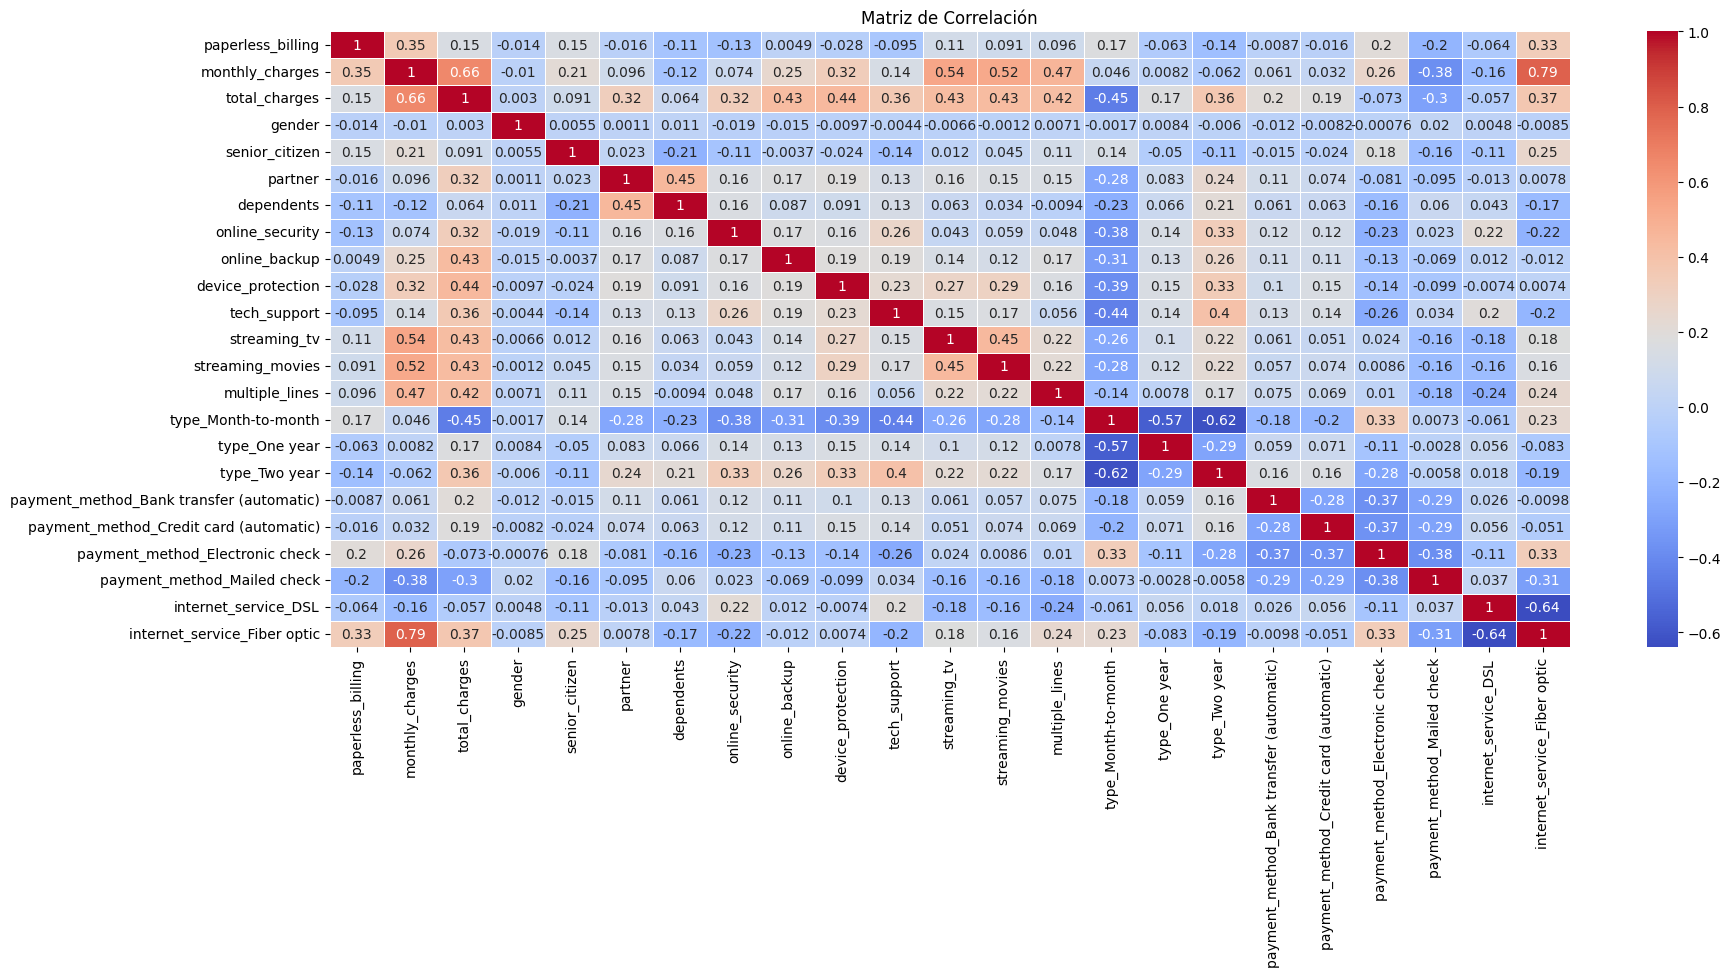

In [4737]:
#Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [4738]:
# Seleccionar las variables dependiente (y) e independiente (X)
# Supongamos que 'target' es la variable dependiente y las demás son independientes
X = features_train_imp
y = target_train

# Añadir una constante a las variables independientes
X = sm.add_constant(X)

# Ajustar el modelo de regresión
model = sm.OLS(y, X).fit()

# Mostrar un resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 cancel   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     94.44
Date:                Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:01:08   Log-Likelihood:                -2203.9
No. Observations:                5070   AIC:                             4452.
Df Residuals:                    5048   BIC:                             4595.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Balanceamos los datos

In [4739]:
#Definimos la función para arreglar el sobremuestreo
def upsample(features, target, repeat):
    #Primero dividimos el conjunto de datos de entrenamiento en positivos y negativos 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #Posteriormente multiplicamos los datos de la clase que tiene menos datos, en este caso la clase 1 y unimos todos los datos
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    #Por último, mesclamos todos los datos con la función shuffle y devolvemos los datos desbalanceados
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=seed
    )

    return features_upsampled, target_upsampled

In [4740]:
#features_train_imp, target_train = upsample(
#    features_train_imp, target_train, 2)

In [4741]:
#smote = SMOTE(random_state=seed)
#features_train_resampled, target_train_resampled = smote.fit_resample(features_train, target_train)

## Entrenamos los modelos

In [4742]:
def eval_model(model,features_valid,target_valid):
    best_random = model.best_estimator_
    random_prediction = best_random.predict(features_valid)
    prob = best_random.predict_proba(features_valid)[:, 1]
    random_accuracy=accuracy_score(target_valid,random_prediction)
    random_f1_score=f1_score(target_valid,random_prediction)
    random_roc_auc=roc_auc_score(target_valid,prob)
    print("Accuracy:",random_accuracy)
    print('f1: ',random_f1_score)
    print('ROC_AUC: ',random_roc_auc)
    print('Best_Model: ',best_random)
    return best_random,random_accuracy,random_f1_score,random_roc_auc

### RandomForest

In [4743]:
params_rf={'max_depth':[3,4,2,1],
         'min_samples_split':[5,10,11,12],
         'n_estimators':[10,20,30,40],
         'min_samples_leaf':[1, 2, 4],
         'bootstrap':[True, False]}

In [4744]:
model_rf=RandomForestClassifier(random_state=seed)
selector_rf = SelectFromModel(estimator=model_rf, threshold='mean')
selector_rf.fit(features_train_imp,target_train)
selected_features_rf = features_train_imp.columns[selector_rf.get_support()].tolist()
print("Características seleccionadas:", selected_features_rf)

Características seleccionadas: ['monthly_charges', 'total_charges', 'type_Month-to-month']


In [4745]:
rs=GridSearchCV(estimator=model_rf,param_grid=params_rf,scoring='f1',cv=2)
rs.fit(features_train_imp[selected_features_rf],target_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 4, 2, 1],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 11, 12],
                         'n_estimators': [10, 20, 30, 40]},
             scoring='f1')

In [4746]:
results_rs=eval_model(rs,features_valid_imp[selected_features_rf],target_valid)

Accuracy: 0.7925867507886435
f1:  0.5394045534150613
ROC_AUC:  0.8489597251383851
Best_Model:  RandomForestClassifier(max_depth=4, min_samples_split=5, n_estimators=30,
                       random_state=12345)


In [4747]:
joblib.dump(results_rs[0],'files/models/best_random_rf.joblib')

['files/models/best_random_rf.joblib']

### LGBM Classifier

In [4748]:
param_dist = {
    'n_estimators':range(50, 201, 50),
    'max_depth': range(1, 21)    
} 

In [4749]:
model_lb=LGBMClassifier(random_state=seed)
selector_lb = SelectFromModel(estimator=model_lb, threshold='mean')
selector_lb.fit(features_train_imp,target_train)
selected_features_lb = features_train_imp.columns[selector_lb.get_support()].tolist()
print("Características seleccionadas:", selected_features_lb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1341, number of negative: 3729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264497 -> initscore=-1.022724
[LightGBM] [Info] Start training from score -1.022724
Características seleccionadas: ['monthly_charges', 'total_charges']


In [4750]:
lb=GridSearchCV(estimator=model_lb,param_grid=param_dist,scoring='f1',cv=2)
lb.fit(features_train_imp[selected_features_lb],target_train)

[LightGBM] [Info] Number of positive: 671, number of negative: 1864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2535, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264694 -> initscore=-1.021711
[LightGBM] [Info] Start training from score -1.021711
[LightGBM] [Info] Number of positive: 670, number of negative: 1865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2535, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264300 -> initscore=-1.023739
[LightGBM] [Info] Start training from score -1.023739
[LightGBM] [Info] Number

GridSearchCV(cv=2, estimator=LGBMClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 21),
                         'n_estimators': range(50, 201, 50)},
             scoring='f1')

In [4751]:
results_lb=eval_model(lb,features_valid_imp[selected_features_lb],target_valid)

Accuracy: 0.7941640378548895
f1:  0.5396825396825397
ROC_AUC:  0.8363205446331997
Best_Model:  LGBMClassifier(max_depth=3, random_state=12345)


In [4752]:
joblib.dump(results_lb[0],'files/models/best_random_lb.joblib')

['files/models/best_random_lb.joblib']

### Catboost

In [4753]:
param_dist = {'iterations': range(50, 201, 50),
    'depth': range(1, 11)
    }

In [4754]:
model_cat=CatBoostClassifier(random_state=seed)
selector_cat = SelectFromModel(estimator=model_cat)
selector_cat.fit(features_train_imp,target_train)
selected_features_cat = features_train_imp.columns[selector_cat.get_support()].tolist()
print("Características seleccionadas:", selected_features_cat)

Learning rate set to 0.020605
0:	learn: 0.6782481	total: 8.41ms	remaining: 8.4s
1:	learn: 0.6641473	total: 13.1ms	remaining: 6.52s
2:	learn: 0.6514162	total: 17.4ms	remaining: 5.79s
3:	learn: 0.6397550	total: 21.8ms	remaining: 5.43s
4:	learn: 0.6285492	total: 25.9ms	remaining: 5.15s
5:	learn: 0.6173688	total: 29.7ms	remaining: 4.92s
6:	learn: 0.6075643	total: 33.6ms	remaining: 4.76s
7:	learn: 0.5990356	total: 36.6ms	remaining: 4.53s
8:	learn: 0.5899853	total: 40.6ms	remaining: 4.47s
9:	learn: 0.5813492	total: 44.3ms	remaining: 4.38s
10:	learn: 0.5727661	total: 47.8ms	remaining: 4.29s
11:	learn: 0.5653730	total: 51.3ms	remaining: 4.22s
12:	learn: 0.5578357	total: 54.4ms	remaining: 4.13s
13:	learn: 0.5509498	total: 57.9ms	remaining: 4.08s
14:	learn: 0.5441513	total: 61ms	remaining: 4.01s
15:	learn: 0.5381500	total: 64.3ms	remaining: 3.95s
16:	learn: 0.5322452	total: 67.4ms	remaining: 3.9s
17:	learn: 0.5270278	total: 70.6ms	remaining: 3.85s
18:	learn: 0.5215752	total: 74ms	remaining: 3.82

In [4755]:
cat=GridSearchCV(estimator=model_cat,param_grid=param_dist,scoring='f1',cv=2)
cat.fit(features_train_imp[selected_features_cat],target_train)

Learning rate set to 0.239044
0:	learn: 0.6234818	total: 685us	remaining: 33.6ms
1:	learn: 0.5776596	total: 1.35ms	remaining: 32.4ms
2:	learn: 0.5472381	total: 2.05ms	remaining: 32.2ms
3:	learn: 0.5254986	total: 2.81ms	remaining: 32.4ms
4:	learn: 0.5111560	total: 3.62ms	remaining: 32.6ms
5:	learn: 0.5016155	total: 4.34ms	remaining: 31.8ms
6:	learn: 0.4909808	total: 5.06ms	remaining: 31.1ms
7:	learn: 0.4829466	total: 5.76ms	remaining: 30.2ms
8:	learn: 0.4758499	total: 6.43ms	remaining: 29.3ms
9:	learn: 0.4719398	total: 7.24ms	remaining: 29ms
10:	learn: 0.4674745	total: 8.12ms	remaining: 28.8ms
11:	learn: 0.4631068	total: 8.96ms	remaining: 28.4ms
12:	learn: 0.4599694	total: 9.65ms	remaining: 27.5ms
13:	learn: 0.4572714	total: 10.3ms	remaining: 26.5ms
14:	learn: 0.4542595	total: 11ms	remaining: 25.7ms
15:	learn: 0.4519315	total: 11.7ms	remaining: 25ms
16:	learn: 0.4503270	total: 12.7ms	remaining: 24.6ms
17:	learn: 0.4483021	total: 13.4ms	remaining: 23.8ms
18:	learn: 0.4470159	total: 13.9m

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001ABDCC95460>,
             param_grid={'depth': range(1, 11),
                         'iterations': range(50, 201, 50)},
             scoring='f1')

In [4756]:
results_cat=eval_model(cat,features_valid_imp[selected_features_cat],target_valid)

Accuracy: 0.7988958990536278
f1:  0.5742904841402338
ROC_AUC:  0.8516972068460902
Best_Model:  <catboost.core.CatBoostClassifier object at 0x000001ABF1602C00>


In [4757]:
joblib.dump(results_cat,'files/models/best_random_cat.joblib')

['files/models/best_random_cat.joblib']

### Logistic Regression

In [4758]:
lr=LogisticRegression(random_state=seed)
selector_lr = SelectFromModel(estimator=lr, threshold='mean')
selector_lr.fit(features_train_imp,target_train)
selected_features_lr = features_train_imp.columns[selector_lr.get_support()].tolist()
print("Características seleccionadas:", selected_features_lr)

Características seleccionadas: ['total_charges', 'type_Month-to-month', 'type_Two year', 'internet_service_DSL', 'internet_service_Fiber optic']


In [4759]:
lr.fit(features_train_imp[selected_features_lr],target_train)

LogisticRegression(random_state=12345)

In [4760]:
best_random_lr = lr
random_prediction = best_random_lr.predict(features_valid_imp[selected_features_lr])
prob_lr = best_random_lr.predict_proba(features_valid_imp[selected_features_lr])[:, 1]
random_accuracy=accuracy_score(target_valid,random_prediction)
random_f1_score=f1_score(target_valid,random_prediction)
random_roc_auc=roc_auc_score(target_valid,prob_lr)
print("Accuracy:",random_accuracy)
print('f1: ',random_f1_score)
print('ROC_AUC: ',random_roc_auc)

Accuracy: 0.7941640378548895
f1:  0.5728314238952537
ROC_AUC:  0.8403082649360565


In [4761]:
joblib.dump(best_random_lr,'files/models/best_random_lr.joblib')

['files/models/best_random_lr.joblib']

Al revisar todos los modelos, podemos ver que el que mejor métrica ROC_AUC tiene es el de Logistic_Regression, por lo cual probaremos este primero, y posteriormente probaremos Catboost

### XG Boost

In [4762]:
param_grid = {'n_estimators': range(50, 201, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    }

In [4763]:
model_xg=XGBClassifier(random_state=12345, use_label_encoder=False, eval_metric='logloss')
selector_xg = SelectFromModel(estimator=model_xg, threshold='mean')
selector_xg.fit(features_train_imp,target_train)
selected_features_xg = features_train_imp.columns[selector_xg.get_support()].tolist()
print("Características seleccionadas:", selected_features_xg)

Características seleccionadas: ['type_Month-to-month', 'internet_service_DSL', 'internet_service_Fiber optic']


In [4764]:
xg=GridSearchCV(estimator=model_xg,param_grid=param_grid,scoring='f1',cv=2)
xg.fit(features_train_imp[selected_features_xg],target_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12345, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': range(50, 201, 50)},
             scoring='f1')

In [4765]:
results_xg=eval_model(xg,features_valid_imp[selected_features_xg],target_valid)

Accuracy: 0.7681388012618297
f1:  0.5983606557377049
ROC_AUC:  0.808012025195648
Best_Model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=12345, ...)


In [4766]:
joblib.dump(results_xg,'files/models/best_random_xg.joblib')

['files/models/best_random_xg.joblib']

### Red Neuronal

,cancel
cancel,100.000000
type_Month-to-month,40.510291
internet_service_Fiber optic,30.801974
payment_method_Electronic check,30.191875
monthly_charges,19.335642
paperless_billing,19.182533
senior_citizen,15.088933
gender,-0.861210
multiple_lines,-1.979150
streaming_tv,-3.705722


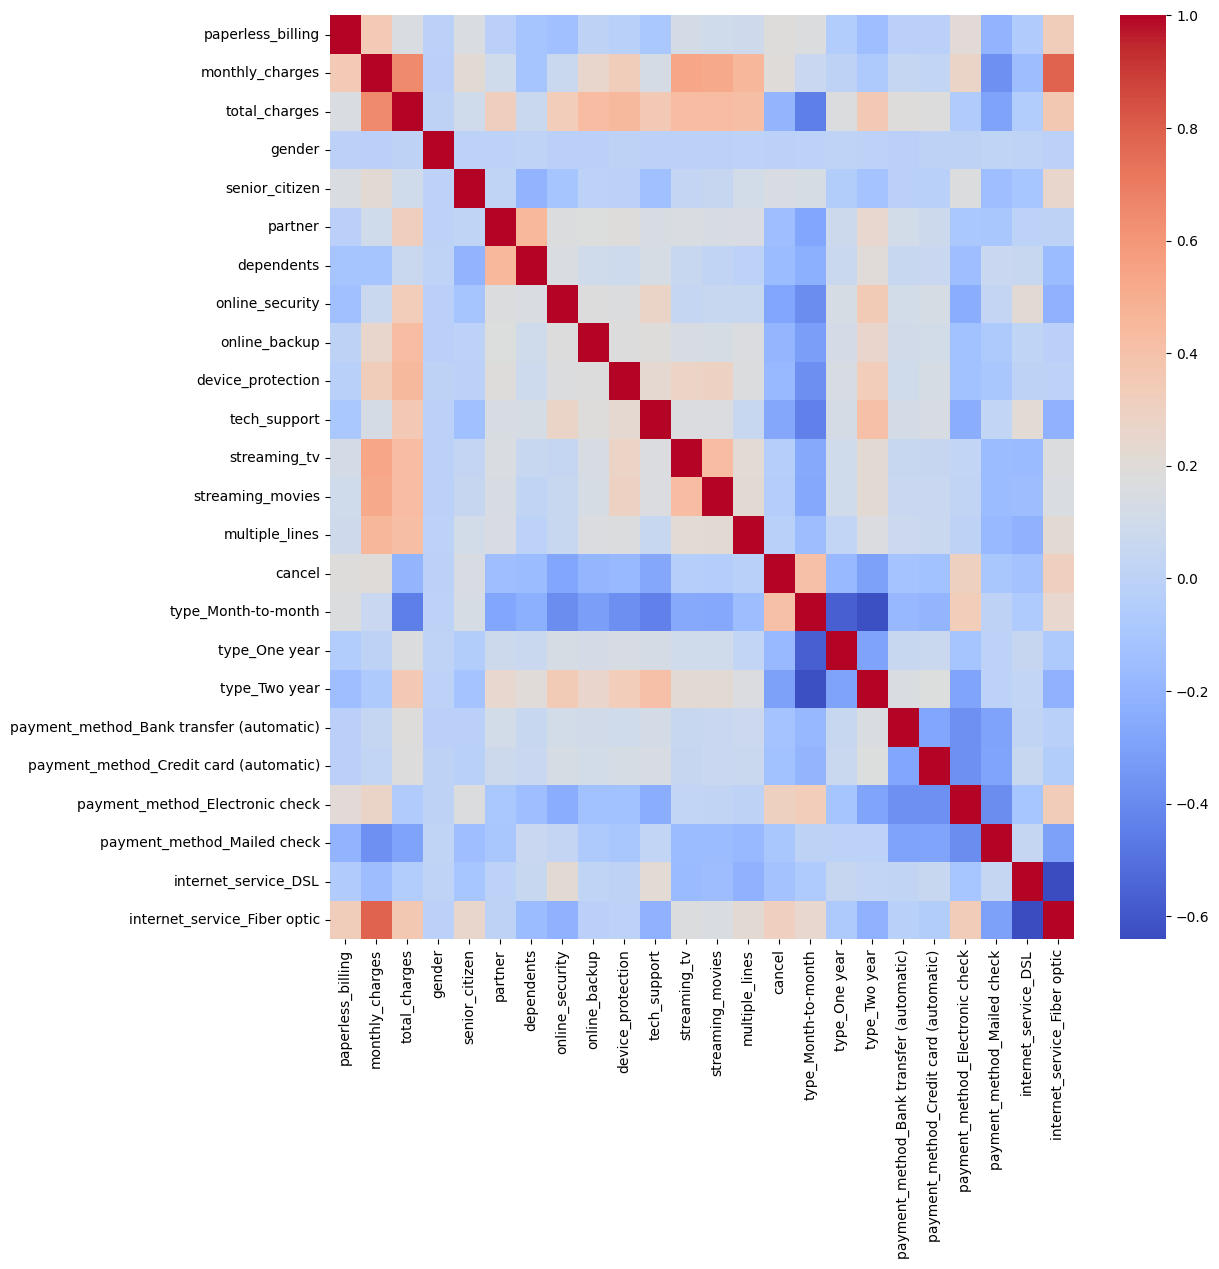

In [4767]:
corr = data_model.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=False, cmap='coolwarm')
corr_results = (corr['cancel']*100).sort_values(ascending=False)
results = pd.DataFrame(corr_results)
selected_columns = corr_results[abs(corr_results)>17].index #Modify ad criteria
results


In [4768]:
selected_columns=selected_columns[1:]
selected_columns

Index(['type_Month-to-month', 'internet_service_Fiber optic',
       'payment_method_Electronic check', 'monthly_charges',
       'paperless_billing', 'device_protection', 'type_One year',
       'online_backup', 'total_charges', 'tech_support', 'online_security',
       'type_Two year'],
      dtype='object')

In [4769]:
features_train_imp_n=features_train_imp[selected_columns]
features_valid_n=features_valid_imp[selected_columns]

In [4772]:
# Model Structure
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #Dropout(0.3),  # Dropout for regularization
        Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #Dropout(0.3),  # Dropout for regularization
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #Dropout(0.3),  # More dropout for regularization        
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #Dropout(0.3),  # More dropout for regularization        
        Dense(1, activation='sigmoid')
    ])
    return model


# Main TensorFlow function
def tens_flow(features_train, features_valid, target_train, target_valid):
    # Compiling the model
    model = build_model(features_train.shape[1])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC()])
    
    # Model summary (optional)
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    #checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
    #model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #filepath=checkpoint_filepath,
    #save_weights_only=True,
    #monitor='val_auc',
    #mode='max',
    #save_best_only=True)

    # Check if GPU is available
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    print(f"Using device: {device}")

    # Training the model using GPU if available
    with tf.device(device):  
        history = model.fit(features_train, target_train, epochs=200, batch_size=64, 
                            validation_data=(features_valid, target_valid), callbacks=[early_stopping])

    # Evaluating the model
    y_pred_proba = model.predict(features_valid).ravel()
    auc_score = roc_auc_score(target_valid, y_pred_proba)
    print(f"AU-ROC Score: {auc_score}")

    return model

In [4773]:
model_n=tens_flow(features_train_imp_n,features_valid_n,target_train,target_valid)

c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

Using device: /CPU:0
Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc: 0.6637 - loss: 0.7599 - val_auc: 0.8261 - val_loss: 0.5894
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8213 - loss: 0.5822 - val_auc: 0.8297 - val_loss: 0.5631
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8392 - loss: 0.5454 - val_auc: 0.8317 - val_loss: 0.5472
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8373 - loss: 0.5374 - val_auc: 0.8308 - val_loss: 0.5329
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8467 - loss: 0.5176 - val_auc: 0.8316 - val_loss: 0.5231
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8415 - loss: 0.5130 - val_auc: 0.8315 - val_loss: 0.5144
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8433 - loss: 0.4916 - val_auc: 0.8350 - val_loss: 0.5040
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8257 - loss: 0.5084 - val_auc: 0.8335 - val_loss: 0.4998
Epoch 9/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2

## Testeamos los datos

### Red neuronal

In [4781]:
features_test_n=features_test_imp[selected_columns]
prediction_n=model_n.predict(features_test_n).ravel()
random_roc_auc_n=roc_auc_score(target_test,prediction_n)
print('ROC_AUC: ',random_roc_auc_n)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ROC_AUC:  0.8510628513030148


### Catboost

In [4775]:
results_cat=eval_model(cat,features_test_imp[selected_features_cat],target_test)

Accuracy: 0.7914893617021277
f1:  0.5689149560117303
ROC_AUC:  0.8494123658661217
Best_Model:  <catboost.core.CatBoostClassifier object at 0x000001ABF1602C00>


### Logistic Regression

In [4782]:
prediction_lr=best_random_lr.predict(features_test_imp[selected_features_lr])
prob_lr = best_random_lr.predict_proba(features_test_imp[selected_features_lr])[:, 1]
random_accuracy=accuracy_score(target_test,prediction_lr)
random_f1_score=f1_score(target_test,prediction_lr)
random_roc_auc_lr=roc_auc_score(target_test,prob_lr)
print("Accuracy:",random_accuracy)
print('f1: ',random_f1_score)
print('ROC_AUC: ',random_roc_auc_lr)

Accuracy: 0.7957446808510639
f1:  0.5838150289017341
ROC_AUC:  0.8428564128768523


### Random Forest

In [4777]:
results_rf=eval_model(rs,features_test_imp[selected_features_rf],target_test)

Accuracy: 0.7872340425531915
f1:  0.5614035087719298
ROC_AUC:  0.8425958099131324
Best_Model:  RandomForestClassifier(max_depth=4, min_samples_split=5, n_estimators=30,
                       random_state=12345)


### Light_GBM

In [4778]:
results_lb=eval_model(lb,features_test_imp[selected_features_lb],target_test)

Accuracy: 0.8
f1:  0.5765765765765766
ROC_AUC:  0.8304547777210016
Best_Model:  LGBMClassifier(max_depth=3, random_state=12345)


### XG_boost

In [4779]:
results_xg=eval_model(xg,features_test_imp[selected_features_xg],target_test)

Accuracy: 0.7815602836879433
f1:  0.6169154228855721
ROC_AUC:  0.8178742973939703
Best_Model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=12345, ...)


## Resultados

In [4783]:
models=['Red Neuronal','Random_Forest','logistic_regression','Light_GBM','Cat_boost','XG_boost']
ROC_AUC=[random_roc_auc_n,results_rf[3],random_roc_auc_lr,results_lb[3],results_cat[3],results_xg[3]]
results={'Modelos':models,'ROC_AUC':ROC_AUC}
results_table=pd.DataFrame(results)
results_table

,Modelos,ROC_AUC
0,Red Neuronal,0.851063
1,Random_Forest,0.842596
2,logistic_regression,0.842856
3,Light_GBM,0.830455
4,Cat_boost,0.849412
5,XG_boost,0.817874


# Conclusiones

1. El modelo que mejor se ajustó a nuestros datos para clasificar las personas que cancelan fue la Red Neuronal con un AUC ROC de 0.851, seguido de CatBoost con 0.849 y LogisticRegression con 0.852.

2. Se utilizó una red neuronal con 5 capas y optimizador adam de 0.0005 de tasa de entrenamiento.

3. Se utilizó la función SelectFromModel para cada modelo con el fin de segmentar las caracteristicas optimas para cada caso específico.

4. Para la red neuronal se seleccionaron las caracteristicas con correlación mayor a 17%.